# Dataset SCIA
Registrazione delle misure recuperate dal database SCIA.

La procedura si articola nei seguenti passaggi:
1. [caricamento dei dati grezzi](#caricamento-da-frammenti) e uniformazione negli schemi esposti sotto;
1. [primo quality check](#quality-check): controllo errori di consistenza nella singola serie e nelle coppie di serie della stessa stazione;
1. [overview disponibilità dati](#overview-disponibilità-dati): plot che mostrano la disponibilità temporale e spaziale di serie;

## Data model
### Metadati
| station_id | station_name | network | state | lon    | lat    | elevation | dataset_id | original_id |
|------------|--------------|---------|-------|--------|--------|-----------|------------|-------------|
| utf8()     | utf8()       | utf8()  | utf8()|double()|double()| double()  | utf8()     | utf8()      |
| pkey       | obs          | obs     | obs   | obs    | obs    | obs       | fkey       | obs         |

I metadati delle stazioni che non rientrano nelle tabelle elencate vanno in una tabella "extra" collegata tramite "station_id".

### Dati
|series_id|date|value|merged|variable|
|---------|----|-----|------|--------|
|utf8()|date()|double()|bool()|utf8()|
| fkey    |obs | obs | obs  | obs    |

Note:
- `merged` indica se il valore in riga è il risultato di un merge.


In [1]:
dataset <- "SCIA"
state <- "Italia"


In [2]:
setwd(fs::path_abs("~/Local_Workspace/TesiMag"))
library(arrow, warn.conflicts = FALSE)
library(dplyr, warn.conflicts = FALSE)
library(zeallot, warn.conflicts = FALSE)
library(stringr, warn.conflicts = FALSE)
options(repr.plot.width = 9, repr.plot.res = 300)


source(str_glue("notebooks/integrazioni_nazionali/SCIA/procedures/load_daily.R"))
source("notebooks/integrazioni_regionali/procedure/common_steps.R")
source("notebooks/integrazioni_regionali/procedure/checkpoint.R")
source("src/database/tools.R")
source("src/database/insert.R")
source("src/database/startup.R")
source("src/database/query/spatial.R")
source("src/database/query/data.R")
source("src/load/ITA.R")

conns <- load_dbs()
ita_boundaries <- query_boundary(conns$stations, "Italia", "country")
add_ds_info(dataset, dataset_spec())


Linking to GEOS 3.11.0, GDAL 3.5.3, PROJ 9.1.0; sf_use_s2() is TRUE



## Caricamento da frammenti
Dati giornalieri come forniti dall'ente, in formato tabella Arrow


In [3]:
daily_dataset <- load_daily_data.scia() |> prepare_daily_data()
save_checkpoint(daily_dataset$checkpoint, dataset, "raw")
write_extra_metadata(daily_dataset$extra_meta |> collect(), dataset, conns$stations)
rm(daily_dataset)
gc()


,used,(Mb),gc trigger,(Mb),limit (Mb),max used,(Mb)
Ncells,2080898,111.2,3615467,193.1,NA,3615467,193.1
Vcells,4519236,34.5,10146329,77.5,16384,7840385,59.9


## Analisi disponibilità dati
Grafici che mostrano la disponibilità di serie mese per mese e sul territorio

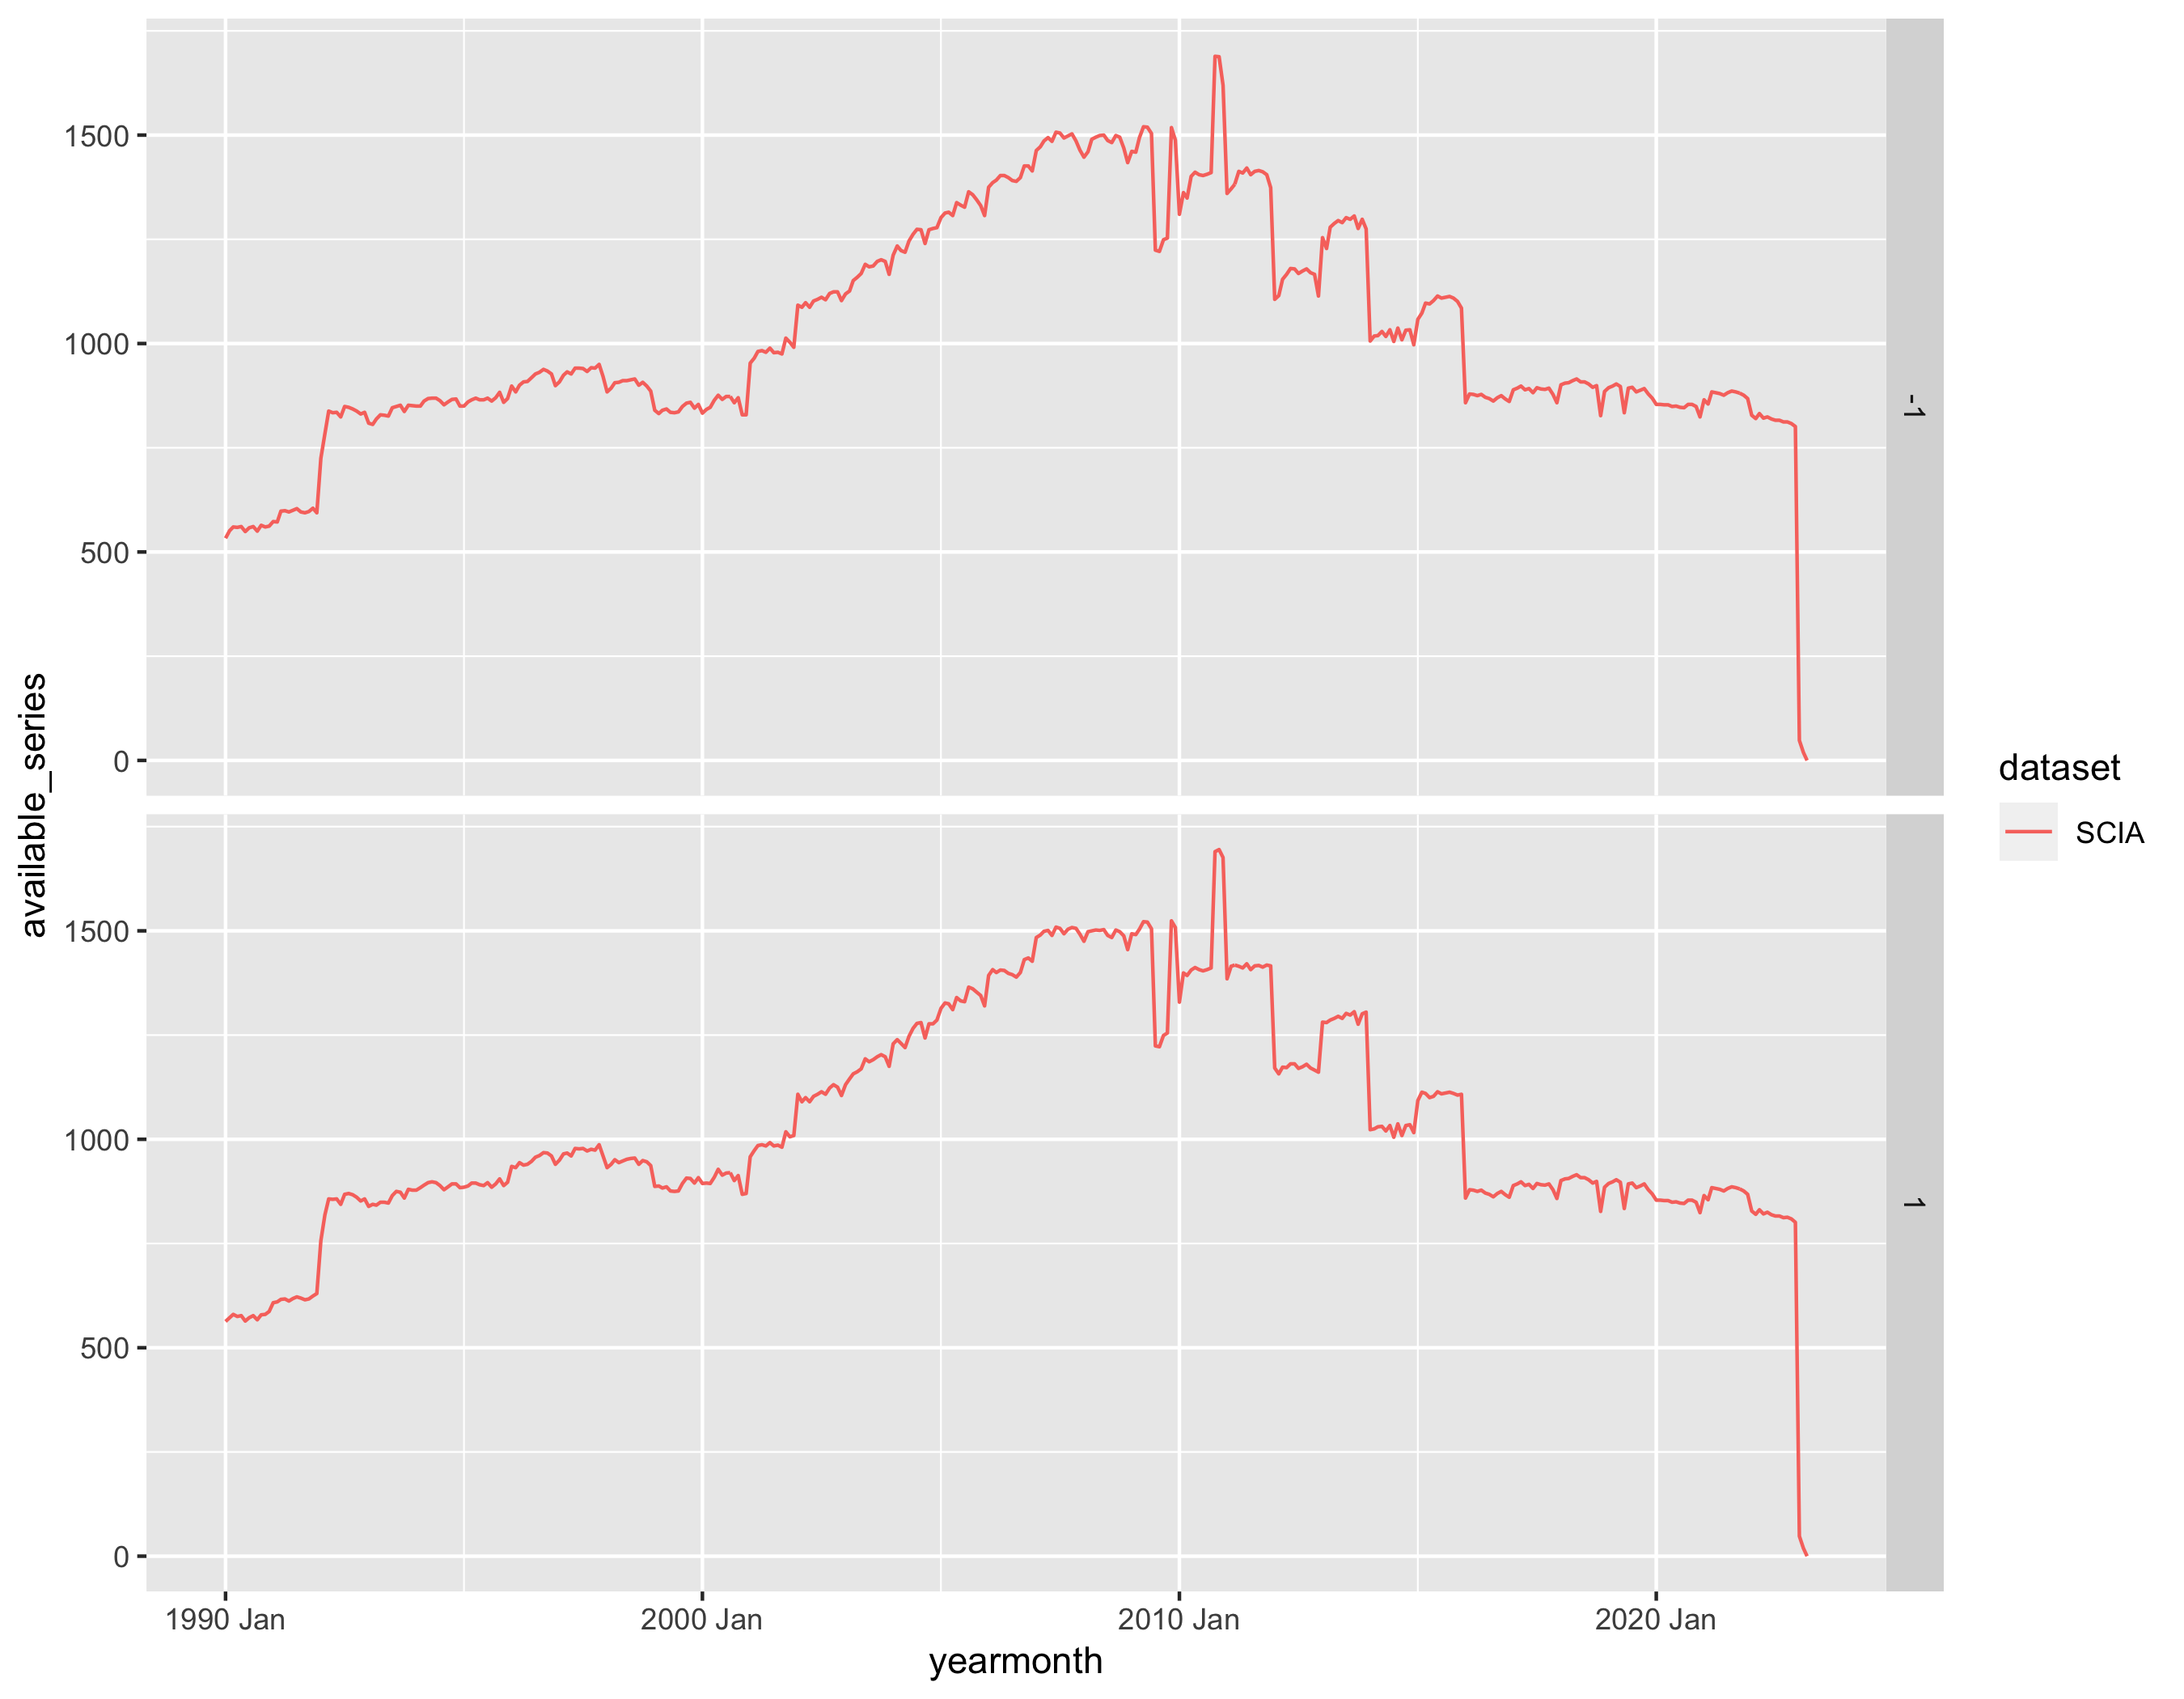

In [5]:
conn <- conns$data
stations <- query_checkpoint_meta(dataset, "raw", conn) |> filter(lat > 42.2 & !(state %in% c("Lazio", "Abruzzo")))
state_data <- query_checkpoint_data(dataset, "raw", conn) |>
    filter(date >= as.Date("1990-01-01")) |>
    semi_join(stations, by = "sensor_key")
c(p, ymonthly_avail) %<-% ymonthly_availabilities(state_data)
p + facet_grid(variable ~ .)


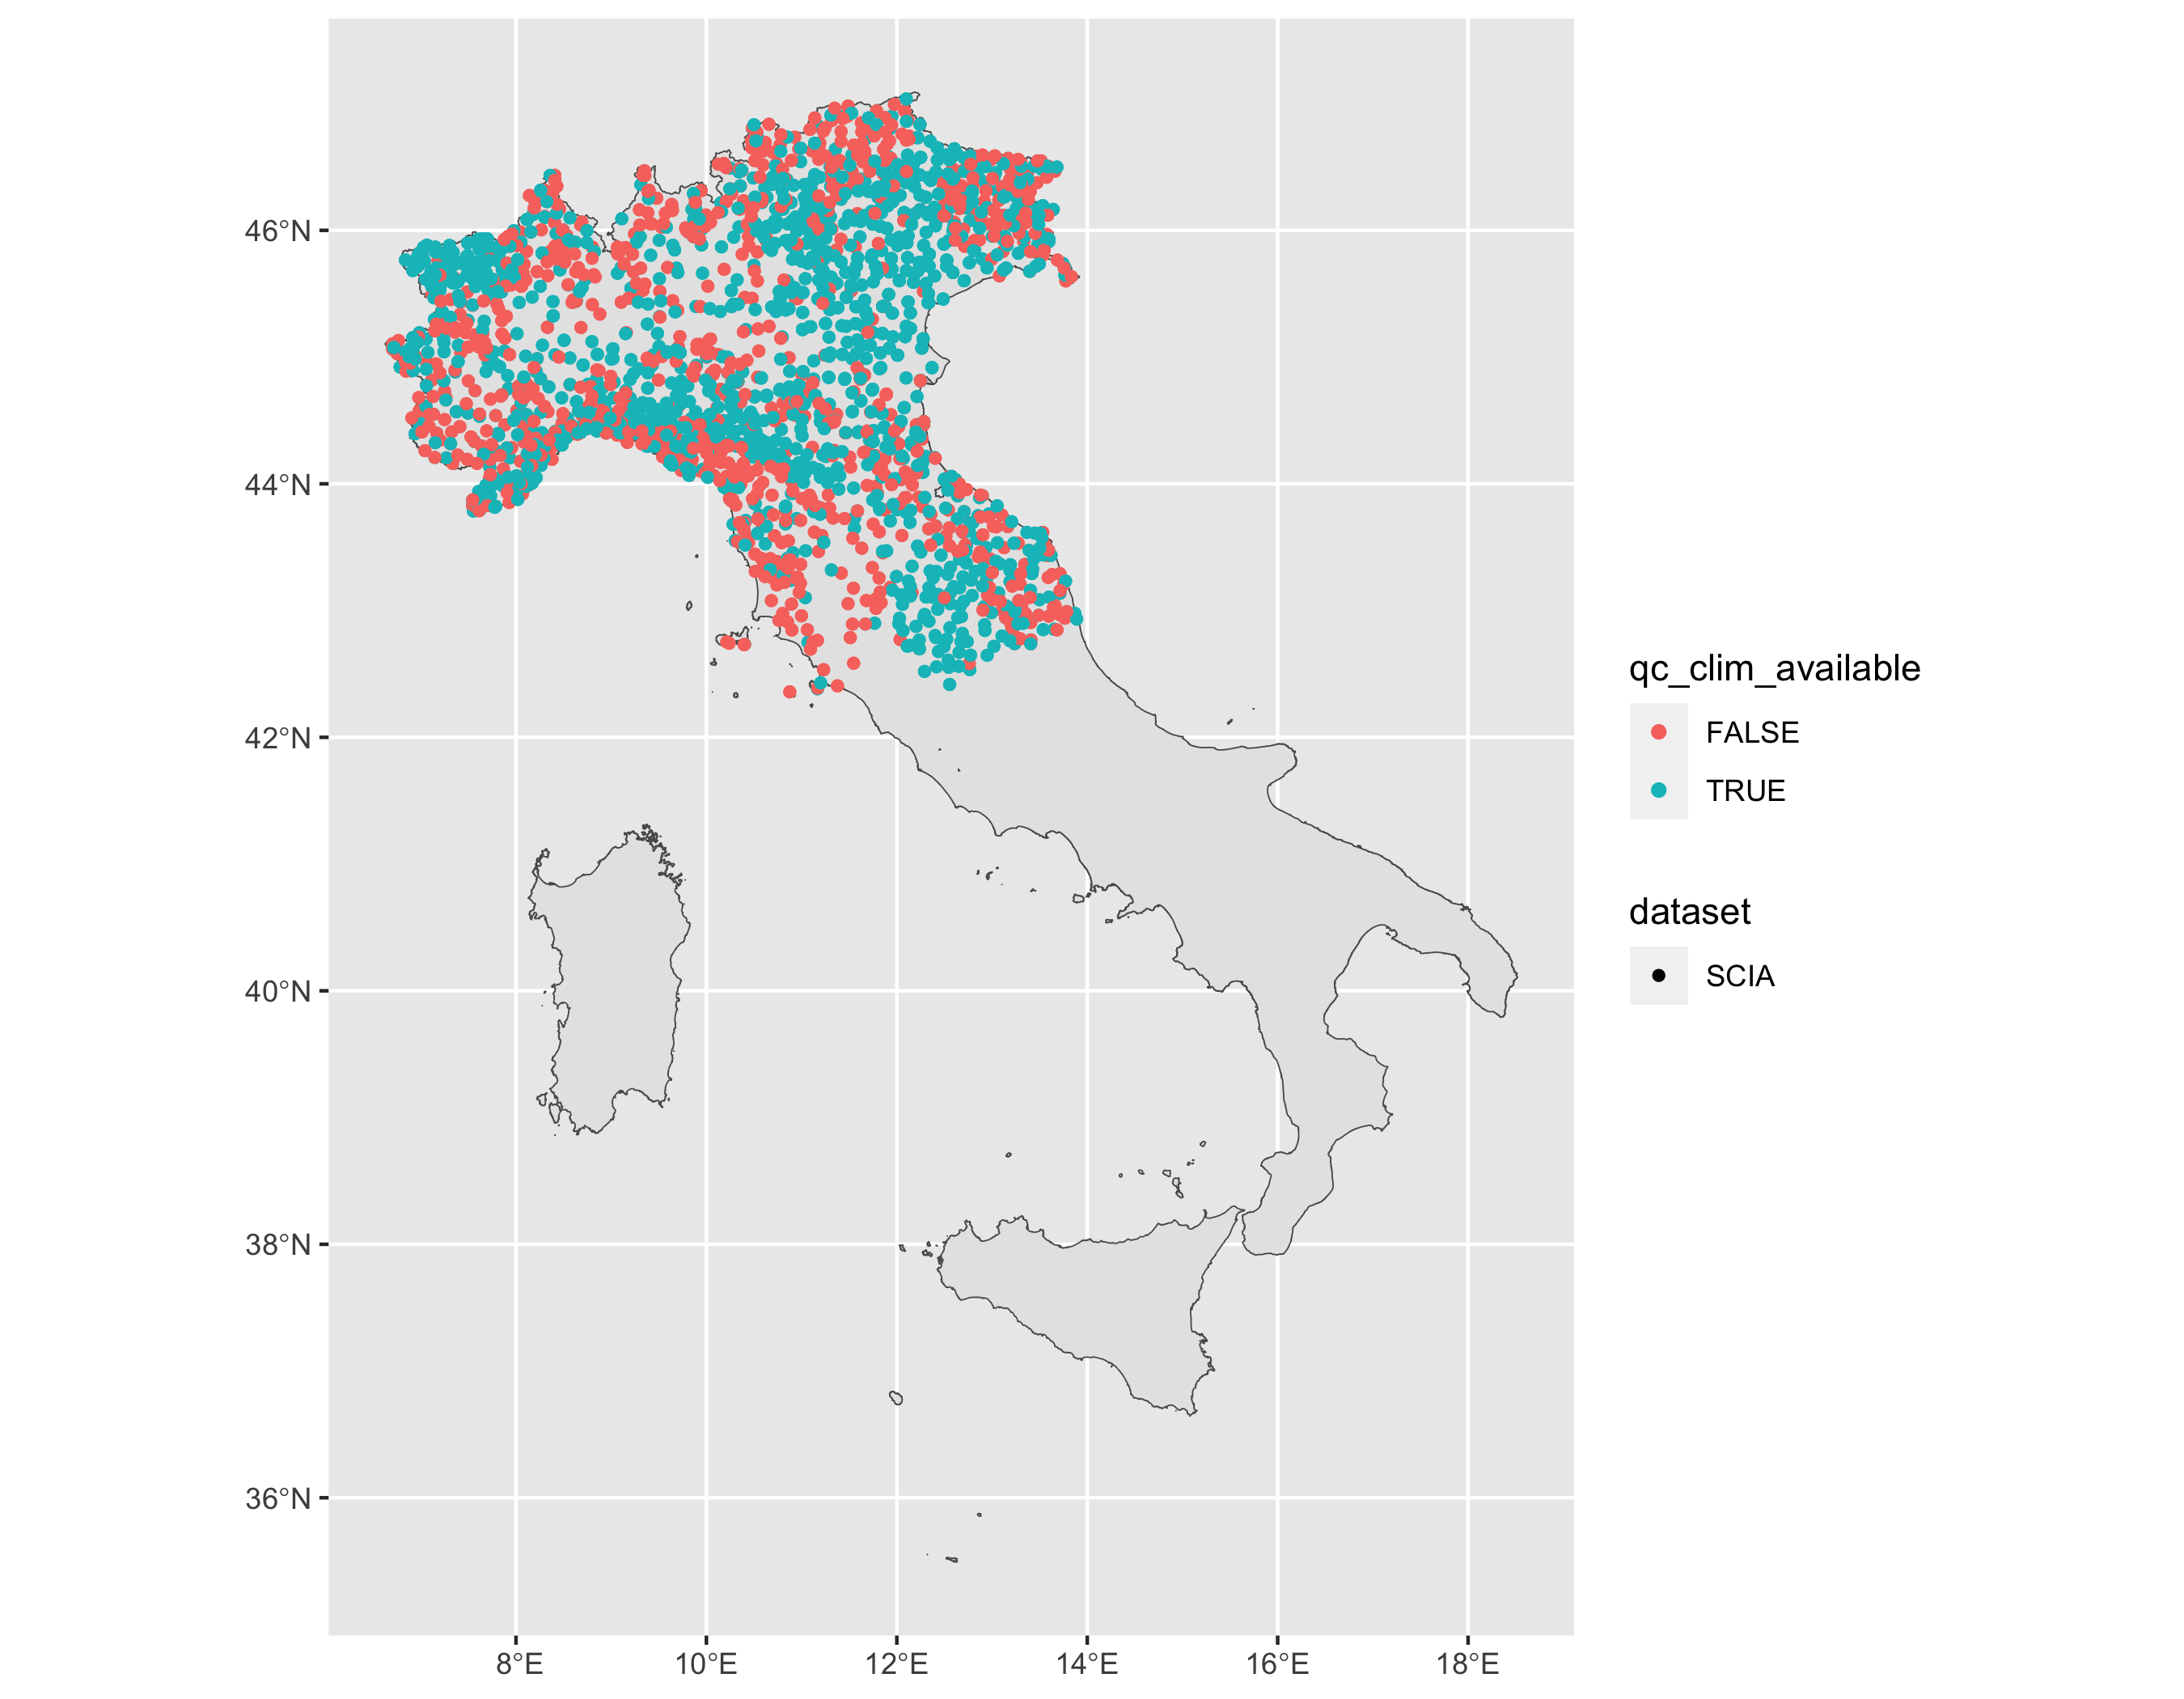

In [6]:
c(p, climats) %<-% spatial_availabilities(ymonthly_avail, stations, ita_boundaries)
p


In [7]:
qc_checkpoint(dataset, conns$data)

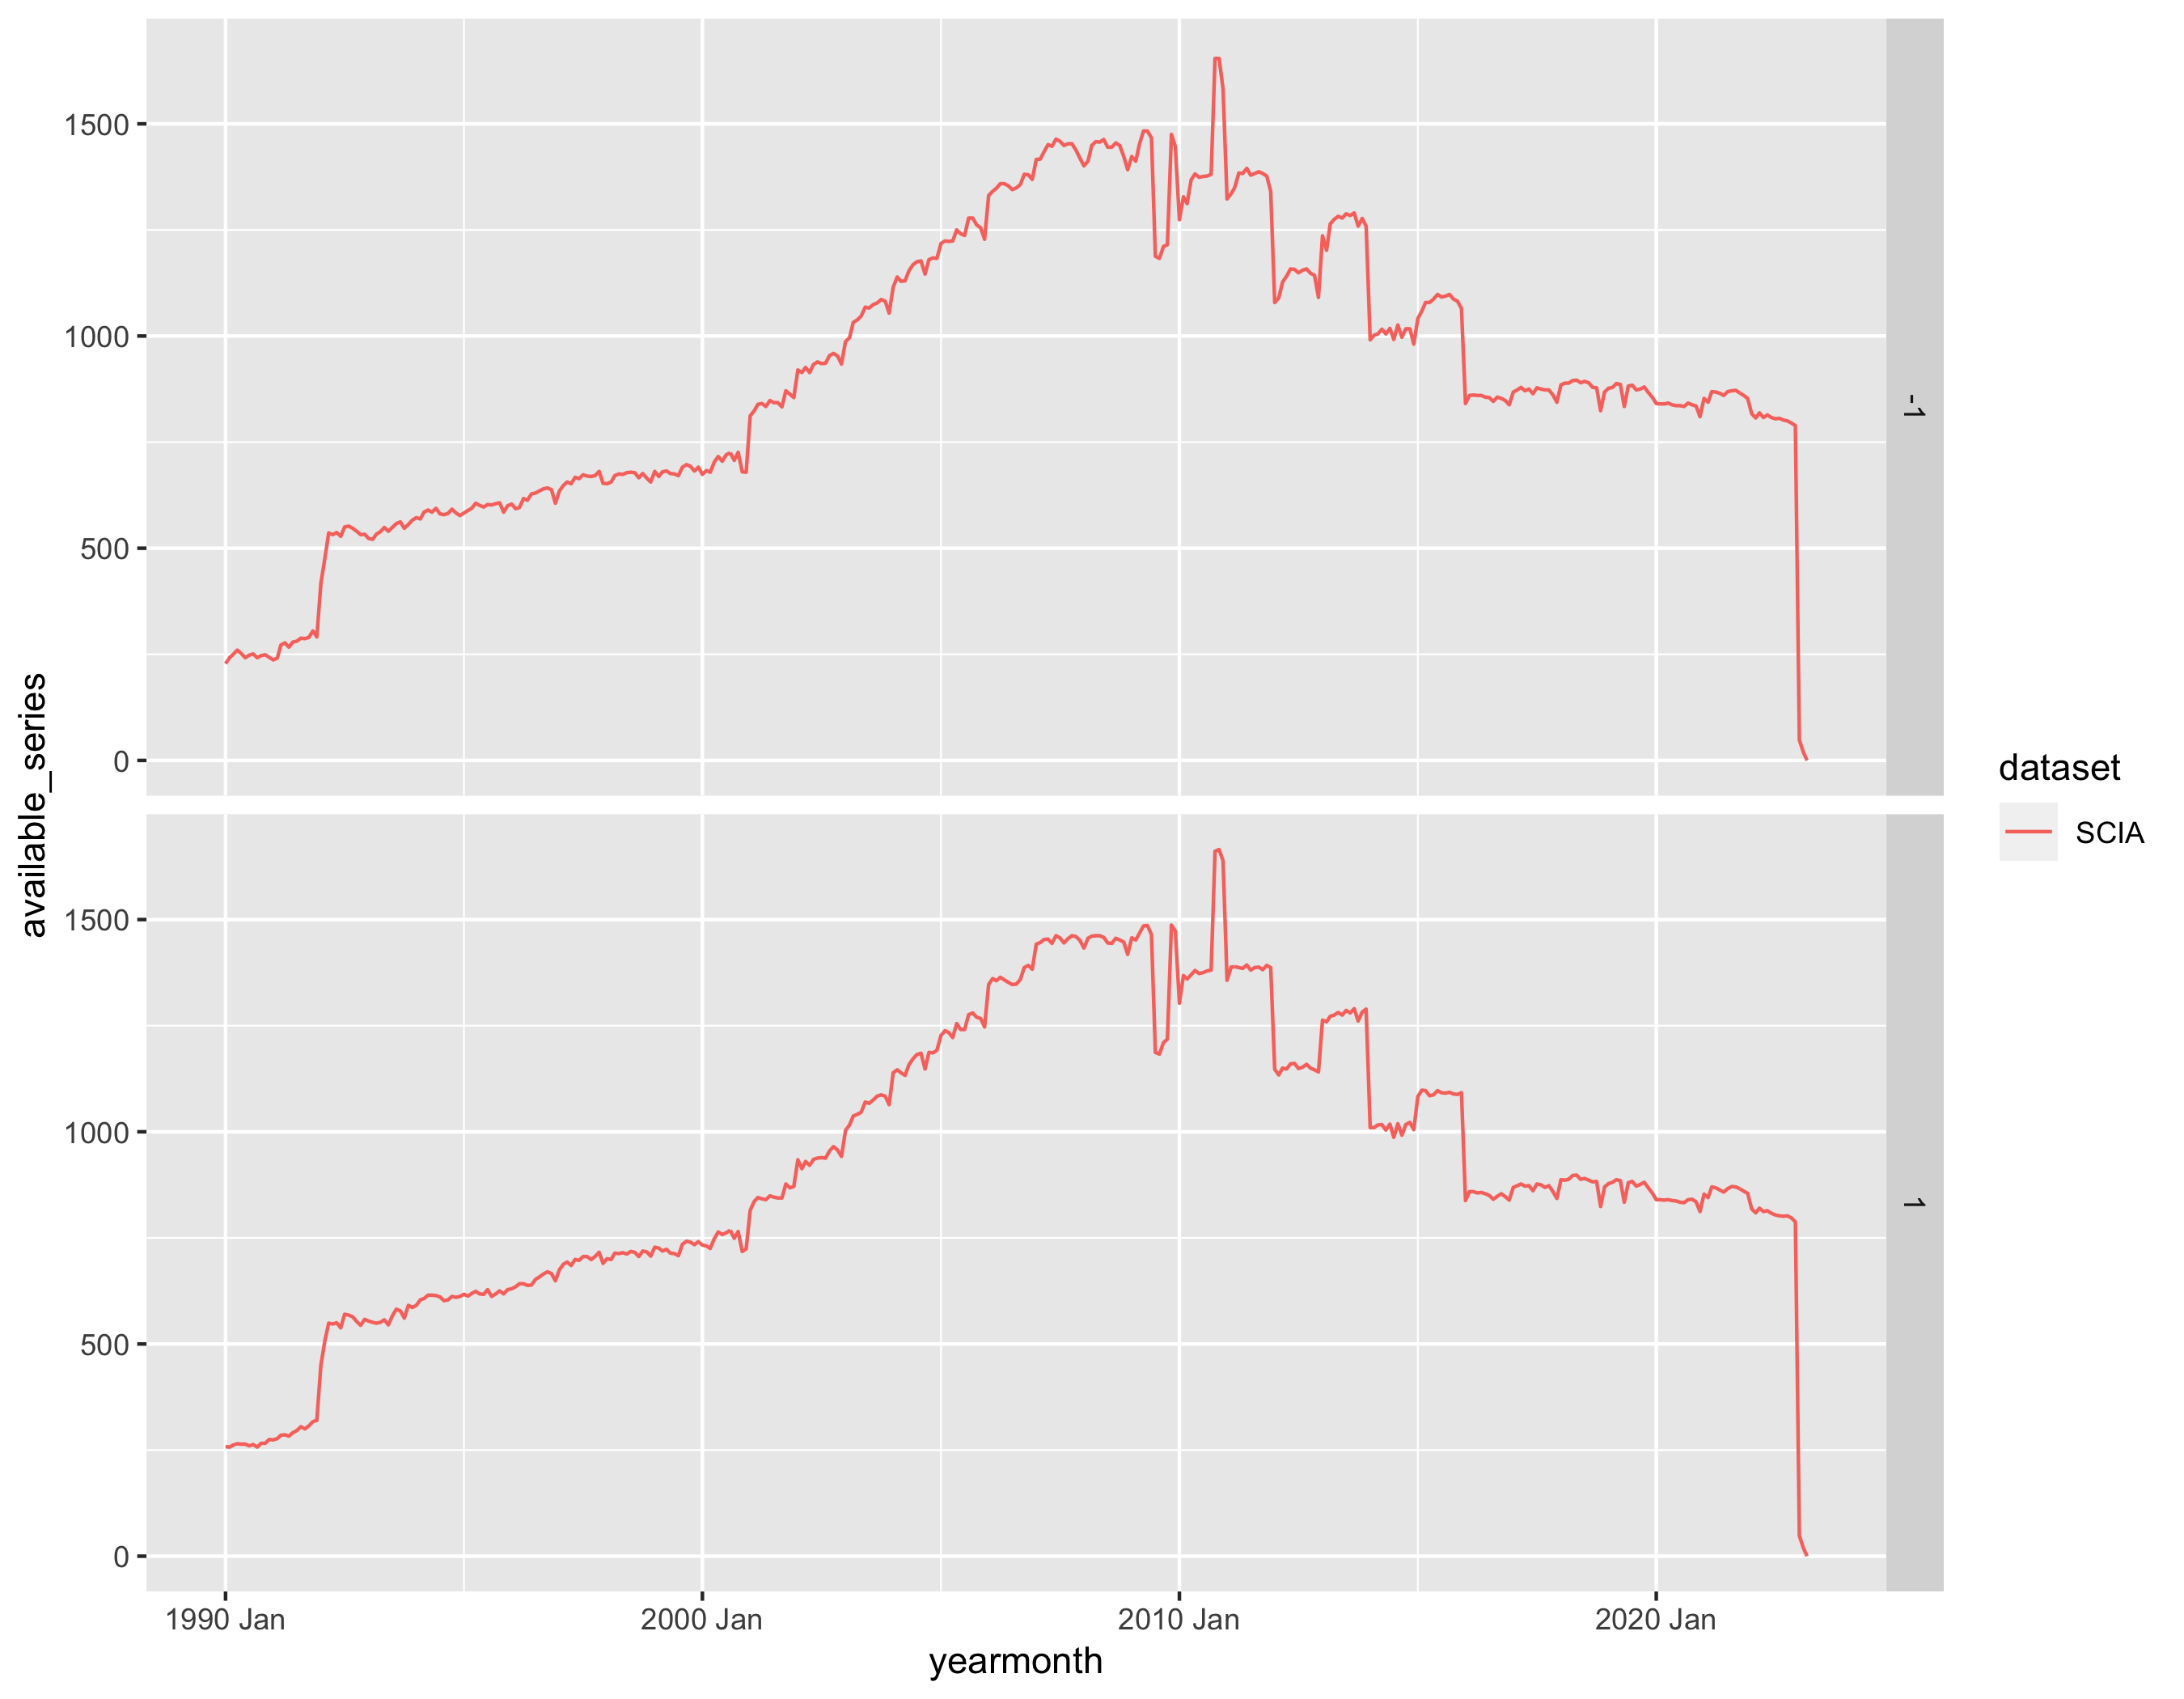

In [8]:
conn <- conns$data
stations <- query_checkpoint_meta(dataset, "raw", conn) |> filter(lat > 42.2 & !(state %in% c("Lazio", "Abruzzo")))
state_data <- query_checkpoint_data(dataset, "qc1", conn) |>
    filter(date >= as.Date("1990-01-01"), valid) |>
    semi_join(stations, by = "sensor_key")
c(p, ymonthly_avail) %<-% ymonthly_availabilities(state_data)
p + facet_grid(variable ~ .)

## Merging
Gap-filling con altri dataset.
Registrazione dell'esito.